# American Housing Stock
Classifying Adequate Units

## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#terms'>Key Terminology</a>
3. <a href='#datasources'>Data Sources</a>
4. <a href='#EDA'>Exploratory Data Analysis</a>
5. <a href='#models'>Classification</a>
 1. <a href='#model1'>Logistic Regression</a> 
 2. <a href='#model2'>Random Forest</a>
 3. <a href='#model3'>SVM</a>
6. <a href='#findings'>Recommendations</a>
7. <a href='#recs'>Next Steps</a>

In [1]:
# Import libraries and set defaults
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from collections import Counter

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
color_palette(palette='flatui', n_colors=8)
from yellowbrick.style import set_palette
set_palette('pastel')

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(42)

import warnings 
warnings.filterwarnings('ignore')

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<a id='goal'></a>
## Problem Statement

This analysis aims to assist the U.S. Department of Housing & Urban Development (HUD) to better understand housing stock.  To evaluate this topic, HUD aims to address the following questions: 

1.  What features are important for classifying units as adequate?
2.  Are these the same features that determine whether a unit is classified as vacant?  What about classifying whether a unit is affordable?

<a id='terms'></a>
## Key Terminology

- **U.S. Department of Housing & Urban Development (HUD)**:  federal agency dedicated to strengthening and supporting the housing market; primary responsibilities include:
  -  Protecting housing consumers
  -  Encouraging production of affordable rental housing
  -  Preventing and punishing discrimination in housing
- **Housing stock**:  total number of houses, apartments, or other dwellings
- **Housing unit**:  a single house, apartment, or other dwelling

<a id='datasources'></a>
## Data Sources

### American Housing Survey (AHS)
(https://www.census.gov/programs-surveys/ahs.html)

-  Biennial voluntary longitudinal survey that provides current and ongoing series of data on the size, composition, and state of housing in the United States and changes in the housing stock over time
-  Collects housing statistics that the U.S. Department of Housing and Urban Development (HUD) uses to evaluate and develop its federal housing programs
-  Sample size dependent on HUD budget and has varied over the years (e.g. in 2009 about 62,000 addresses were selected for the National survey)
-  Each sample unit from the basic sample has been visited every other year since 1985. New addresses are added to the sample at each iteration to ensure representativeness 

In [3]:
# import data
clean_df = pd.read_csv('data/ahs.csv')

<a id='EDA'></a>
## Exploratory Data Analysis

In [4]:
# Create dummy model
X = clean_df.drop(['ADEQUACY_BIN'], axis=1)
y = clean_df.ADEQUACY_BIN

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_labels = list(X.columns)

In [5]:
# always predicts the most frequent label in the training set
dummy0 = DummyClassifier(strategy='most_frequent').fit(X_train_0, y_train_0)
dummy0.fit(X_train_0, y_train_0)
dummy0.score(X_test_0, y_test_0)

0.9316156093176541

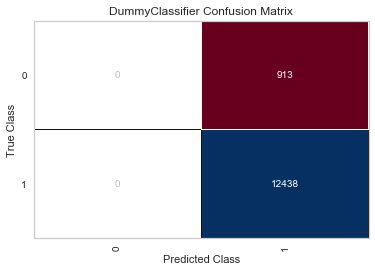

In [11]:
cm = ConfusionMatrix(dummy0, cmap='RdBu');
cm.score(X_test_0, y_test_0);
cm.poof();

In [12]:
# Balancing classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 62185, 0: 62185})


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

<a id='models'></a>
## Classification

<a id='model1'></a>
### 1)  Random Forest

In [32]:
# Creating a pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(max_depth=30))])

In [33]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     12437
           1       0.80      0.80      0.80     12437

    accuracy                           0.80     24874
   macro avg       0.80      0.80      0.80     24874
weighted avg       0.80      0.80      0.80     24874



In [34]:
# Set up grid search
param_grid = dict(clf__n_estimators = [80,100,120],
                  clf__max_depth = [25,30,35,40],
                  clf__min_samples_split = [1, 5, 20, 100],
                  clf__min_samples_leaf = [1, 2, 5, 10],
                  clf__random_state=[42])

grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
rf_est_list = [estimator.get_depth() for estimator in pipe[1].estimators_]

In [ ]:
feats = {}
for feature, importance in zip(X_labels, pipe[1].feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances.head(20)

<a id='model2'></a>
### 2)  Logistic Regression

<a id='model3'></a>
### 3)  SVM

In [ ]:


clf_svm = SVC(kernel='polynomial')
clf_svm.fit(X_train, y_train)

print(clf.predict(X_test))

<a id='findings'></a>
## Recommendations

Legal clinic can address issues related to D.C. housing by:
1.  Taking into account the disproportionate impact of evictions on D.C.’s non-white population by setting up clinics in historically black communities
2.  Advocate that PUDs follow through on community benefits such as the provision of affordable housing or charitable contribution to local nonprofit focused on equitable development

<a id='recs'></a>
## Next Steps

1. Continue analysis at block group level, accounting for the fact that a PUD may be adjacent to one or more block groups
2. Repeat analysis, taking into account PUD status as of 2016 (year of eviction rate data)
3. Evaluate findings across time series data, including development timeline of PUD
4. Repeat analysis with other development vehicles, such as Tax Increment Financing
5. Synthesize findings with additional research about PUD community impact beyond count of affordable units, such as count of family-sized units, project value, etc.
